In [12]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np

In [13]:
# BELOW IS RAW DAILY DATA
all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_deaths.csv")
all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_infections.csv")
all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

merged_df = pd.merge(infected, deaths, on='date', how='outer')

In [14]:
# # BELOW IS RAW WEEKLY DATA
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_deaths.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_infections.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

# deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
# infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

# merged_df = pd.merge(infected, deaths, on='date', how='outer')

In [15]:
# # BELOW IS 7 day rolling
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\daily_deaths.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\7_day_rolling_infections.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

# deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
# infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

# merged_df = pd.merge(infected, deaths, on='date', how='outer')

In [16]:
# # CUMULATIVE DATA -> weekly data
# all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_weeky_death.csv")
# all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

# all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\cum_weekly_infection.csv")
# all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

In [17]:
all_county_exemption_rates = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\exemption_rates.xlsx")
all_county_population = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\county_size_N.xlsx")

In [18]:
efficacy = 0.95 # measles vaccine efficacy (average of cdc stats for 1 and 2 doses)
county_name = 'Texas'

deaths = all_county_deaths.set_index('date')
infected = all_county_infected.set_index('date')

exemption = all_county_exemption_rates[all_county_exemption_rates['County'] == county_name]
exemption_val = float(exemption['Exemption Rate'].values[0])

population = all_county_population[all_county_population['County'] == county_name]
pop_val = int(population['Population'].values[0])

N = pop_val*(exemption_val+((1-exemption_val)*(1-efficacy)))

# S0 = N*(exemption_val+((1-exemption_val)*(1-efficacy)))
R0 = 0
# print(S0)

In [ ]:
# merged_df = pd.concat([infected.rename("Cumulative Infected"), 
#                        deaths.rename("Cumulative Deaths")], axis=1)

# merged_df = merged_df.reset_index().rename(columns={'index': 'Date'})

# # print(merged_df.head())
# # print(merged_df.columns.tolist())

# EKF Sim

RMSE(Cumulative Infected): 128.614, R²=-8.6396
RMSE(Cumulative Deaths):   1.027, R²=-14.8947


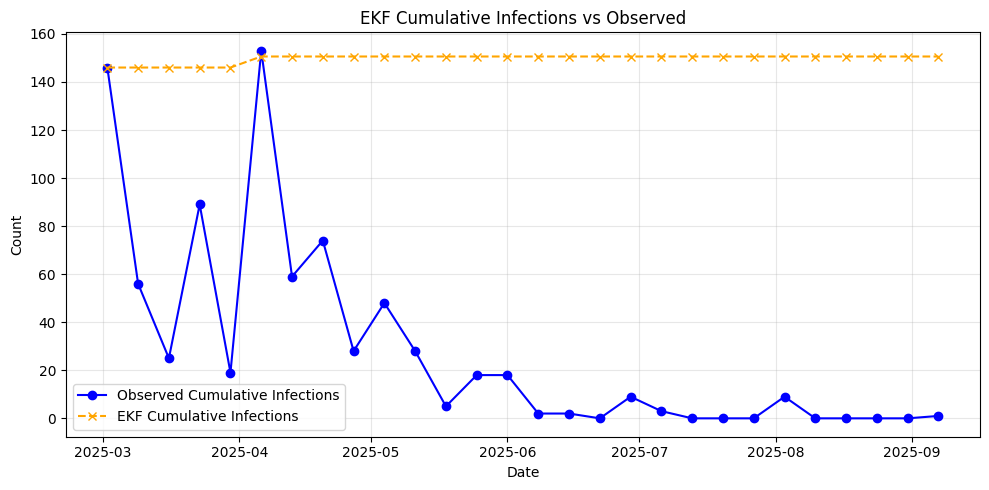

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score


C0 = int(merged_df['Cumulative Infected'].iloc[0])
D0 = int(merged_df['Cumulative Deaths'].iloc[0])
I0 = float(C0)              # assumption: I0 = C0 initially
S0 = float(N - C0 - D0)     # mass balance; R0 assumed 0 at t0
beta0, gamma0, delta0 = 0.77, 0.42, 0.01

# State vector: [S, I, D, C, beta, gamma, delta]
x0 = np.array([S0, I0, D0, C0, beta0, gamma0, delta0], dtype=float)

# Covariance initialization
P0 = np.diag([
    (0.05 * max(S0, 1.0))**2,
    (0.20 * max(I0, 1.0))**2,
    (0.20 * max(D0, 1.0))**2,
    (0.10 * max(C0, 1.0))**2,
    1e-2,
    1e-3,
    1e-4,
])

dt = 1.0
n_steps = len(merged_df)

# Measurement noise covariance (observing C and D)
R_cov = np.diag([0.05**2, 0.01**2])

# --- Process dynamics ---
def f_continuous(x, N):
    S, I, D, C, beta, gamma, delta = x
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dD = delta * I
    dC = beta * S * I / N
    dBeta = 0
    dGamma = 0
    dDelta = 0
    return np.array([dS, dI, dD, dC, dBeta, dGamma, dDelta])

# --- Process noise ---
def compute_Q(x, N):
    S, I, D, C, beta, gamma, delta = x
    p1 = max(beta * S * I / N, 0.0)  # infection
    p2 = max(gamma * I, 0.0)         # recovery
    p3 = max(delta * I, 0.0)         # death

    # lambda for each transition S I D C beta gamma delta 
    lam1 = np.array([-1, +1, 0, +1, 0, 0, 0])
    lam2 = np.array([0, -1, 0, 0, 0, 0, 0])
    lam3 = np.array([0, -1, +1, 0, 0, 0, 0])

    Q_SID = (
        p1 * np.outer(lam1, lam1)
        + p2 * np.outer(lam2, lam2)
        + p3 * np.outer(lam3, lam3)
    )

    Q = np.zeros((7, 7))
    Q[:4, :4] += Q_SID[:4, :4]  # Process noise for S,I,D,C states
    Q[4, 4] = 1e-6   # beta drift
    Q[5, 5] = 1e-7   # gamma drift
    Q[6, 6] = 1e-8   # delta drift
    return Q

# --- Jacobian of f wrt x ---
def jacobian_F(x, N):
    S, I, D, C, beta, gamma, delta = x
    F = np.eye(7)

    F[0, 0] += -beta * I / N * dt
    F[0, 1] += -beta * S / N * dt
    F[0, 4] += -S * I / N * dt

    F[1, 0] +=  beta * I / N * dt
    F[1, 1] += ((beta * S / N) - gamma - delta) * dt
    F[1, 4] +=  S * I / N * dt
    F[1, 5] += -I * dt
    F[1, 6] += -I * dt

    F[2, 1] +=  delta * dt

    F[3, 0] +=  beta * I / N * dt
    F[3, 1] +=  beta * S / N * dt
    F[3, 4] +=  S * I / N * dt   # <-- new: dC/dbeta * dt

    return F

# --- Observation model ---
def h(x, N):
    S, I, D, C, beta, gamma, delta = x
    return np.array([C, D])

def jacobian_H(x, N):
    H = np.zeros((2, 7))
    H[0, 3] = 1  # dC/dC
    H[1, 2] = 1  # dD/dD
    return H

# --- EKF Loop ---
x_est = np.zeros((7, n_steps))
P_est = np.zeros((7, 7, n_steps))
x_est[:, 0] = x0
P = P0

for k in range(1, n_steps):
    x_prev = x_est[:, k-1].copy()
    P_prev = P.copy()

    # Predict
    f_x = f_continuous(x_prev, N)
    x_pred = x_prev + f_x * dt
    F = jacobian_F(x_prev, N)
    Q_k = compute_Q(x_prev, N)
    P_pred = F @ P_prev @ F.T + Q_k

    # keep cumulative states non-decreasing in prediction if you want (optional)
    x_pred[3] = max(x_est[3, k-1], x_pred[3])  # C non-decreasing
    x_pred[2] = max(x_est[2, k-1], x_pred[2])  # D non-decreasing

    # Update
    y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].iloc[k].to_numpy()
    z_pred = h(x_pred, N)
    H = jacobian_H(x_pred, N)

    S_mat = H @ P_pred @ H.T + R_cov
    K = P_pred @ H.T @ np.linalg.inv(S_mat)
    innovation = y_obs - z_pred

    # compute update
    x_upd = x_pred + K @ innovation

    # enforce non-negativity on states
    x_upd = np.maximum(x_upd, 0.0)

    # now clip beta/gamma/delta to [0,1] — these are indices 4,5,6 for your 7-length state
    # make sure x_upd has length 7
    if x_upd.shape[0] != 7:
        raise ValueError(f"Unexpected state length {x_upd.shape[0]}; expected 7.")

    x_upd[4] = np.clip(x_upd[4], 0.0, 1.0)  # beta
    x_upd[5] = np.clip(x_upd[5], 0.0, 1.0)  # gamma
    x_upd[6] = np.clip(x_upd[6], 0.0, 1.0)  # delta

    # optionally ensure cumulative states still non-decreasing after update
    x_upd[3] = max(x_est[3, k-1], x_upd[3])
    x_upd[2] = max(x_est[2, k-1], x_upd[2])

    # Joseph form covariance update
    I7 = np.eye(7)
    P = (I7 - K @ H) @ P_pred @ (I7 - K @ H).T + K @ R_cov @ K.T

    # store
    x_est[:, k] = x_upd
    P_est[:, :, k] = P

# --- Extract estimates ---
S_est, I_est, D_est, C_est, beta_est, gamma_est, delta_est = x_est
actual_C = merged_df['Cumulative Infected'].to_numpy()
actual_D = merged_df['Cumulative Deaths'].to_numpy()

# --- Metrics ---
rmse_C = root_mean_squared_error(actual_C, C_est)
r2_C = r2_score(actual_C, C_est)
rmse_D = root_mean_squared_error(actual_D, D_est)
r2_D = r2_score(actual_D, D_est)
print(f"RMSE(Cumulative Infected): {rmse_C:.3f}, R²={r2_C:.4f}")
print(f"RMSE(Cumulative Deaths):   {rmse_D:.3f}, R²={r2_D:.4f}")

# --- Plot results ---
dates = merged_df['date']
plt.figure(figsize=(10, 5))
plt.plot(dates, actual_C, 'o-', label="Observed Cumulative Infections", color='blue')
plt.plot(dates, C_est, 'x--', label="EKF Cumulative Infections", color='orange')
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("EKF Cumulative Infections vs Observed")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

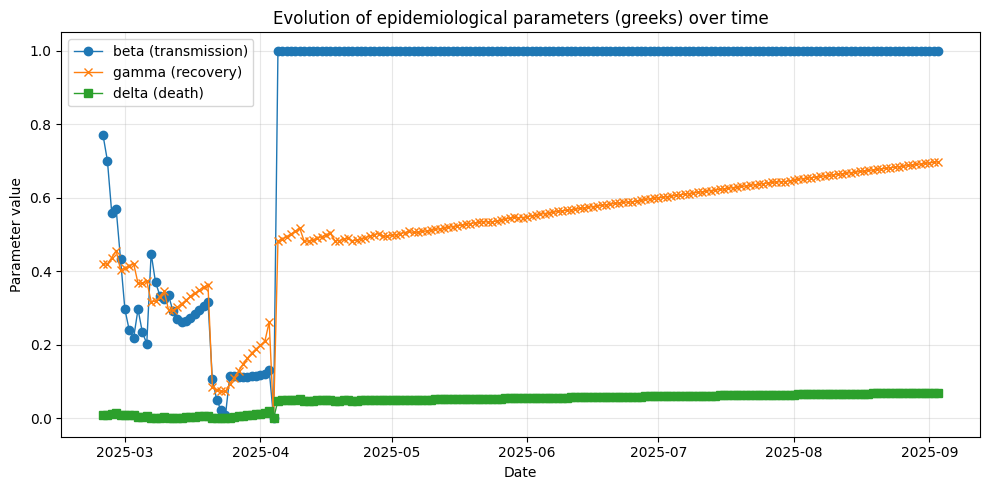

In [40]:
# --- plot greeks (plain parameters) ---
import matplotlib.pyplot as plt

dates = merged_df['date']  # or dates variable you already have

beta_series = x_est[4, :]   # beta over time
gamma_series = x_est[5, :]  # gamma over time
delta_series = x_est[6, :]  # delta over time

plt.figure(figsize=(10,5))
plt.plot(dates, beta_series, label='beta (transmission)', marker='o', linewidth=1)
plt.plot(dates, gamma_series, label='gamma (recovery)', marker='x', linewidth=1)
plt.plot(dates, delta_series, label='delta (death)', marker='s', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Parameter value')
plt.title('Evolution of epidemiological parameters (greeks) over time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd

# Load existing CSV
csv_path = r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\combined graphs\cum_daily.csv"
df_existing = pd.read_csv(csv_path)

# Convert 'date' column to datetime
df_existing['date'] = pd.to_datetime(df_existing['date'])

# Your EKF model predicts these arrays:
# assumed you have numpy arrays named C_est (predicted infections from EKF) and actual_C (true infections)
# also create a date range that matches your EKF outputs (assumed same length as df_existing)
dates = df_existing['date']

# Create new DataFrame with EKF predicted and true infections
df_new = pd.DataFrame({
    'date': dates,
    'EKF Predicted': C_est,
    'EKF True': actual_C
})

# Merge on 'date' column; keeps all from existing, adds EKF columns
df_merged = pd.merge(df_existing, df_new, on='date', how='left')

# Save merged DataFrame back to CSV
df_merged.to_csv(csv_path, index=False)

print(f"Merged EKF predictions into {csv_path}")


Merged EKF predictions into C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\combined graphs\cum_daily.csv


C:\Users\msnin\AppData\Local\Temp\ipykernel_976\149961645.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


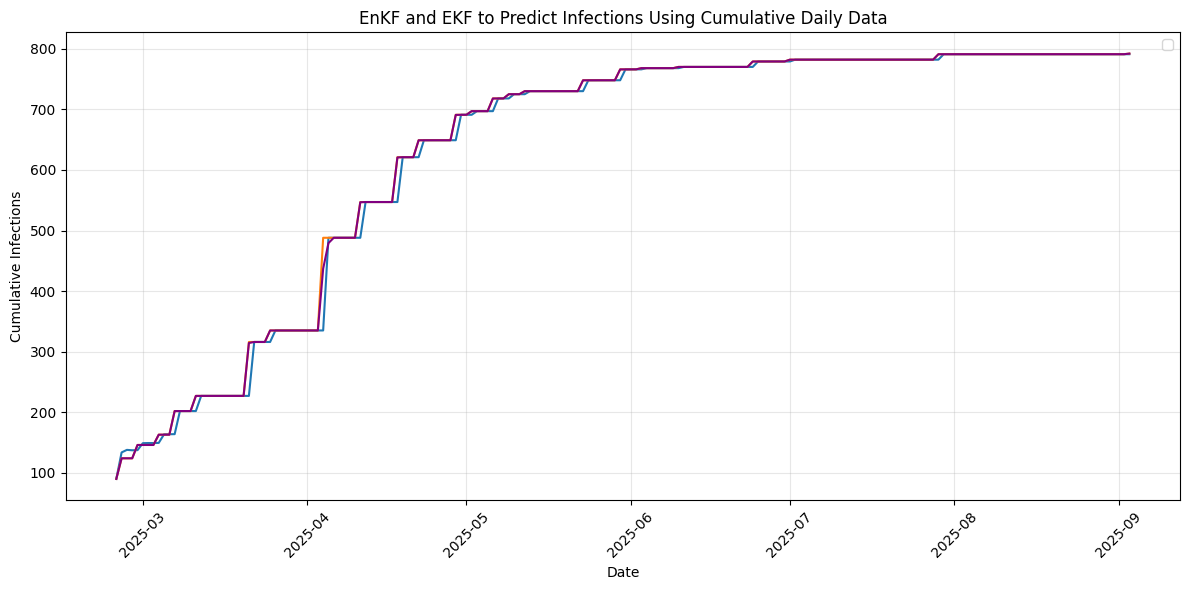

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv(csv_path)

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['ENKF Predicted'], label='')
plt.plot(df['date'], df['True Infections'], label='')
plt.plot(df['date'], df['EKF Predicted'], label='', color = 'purple')

plt.xlabel('Date')
plt.ylabel('Cumulative Infections')
plt.title('EnKF and EKF to Predict Infections Using Cumulative Weekly Data')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Curiousity: ENKF until param convergence, then EKF

trains EnKF then applies EKF starting from 0

In [10]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import root_mean_squared_error, r2_score
# import matplotlib.pyplot as plt

# # --- ENKF definitions ---

# def sird_step_aug(state_aug, N, dt):
#     S, I, R, D, C, beta, gamma, delta = state_aug
#     new_infections = beta * S * I / N
#     dS = -new_infections
#     dI = new_infections - gamma * I - delta * I
#     dR = gamma * I
#     dD = delta * I
#     S_new = max(S + dS * dt, 0)
#     I_new = max(I + dI * dt, 0)
#     R_new = max(R + dR * dt, 0)
#     D_new = max(D + dD * dt, 0)
#     C_new = C + new_infections
#     beta_new = beta + np.random.normal(0, 0.0002)
#     gamma_new = gamma + np.random.normal(0, 0.0002)
#     delta_new = delta + np.random.normal(0, 0.0002)
#     beta_new = np.clip(beta_new, 0, 1)
#     gamma_new = np.clip(gamma_new, 0, 1)
#     delta_new = np.clip(delta_new, 0, 1)
#     return np.array([S_new, I_new, R_new, D_new, C_new, beta_new, gamma_new, delta_new])

# def enforce_mass(state_ens, N):
#     np.maximum(state_ens, 0.0, out=state_ens)
#     total_IRD = state_ens[:, 1:4].sum(axis=1)
#     ok = total_IRD <= N
#     state_ens[ok, 0] = N - total_IRD[ok]
#     over = ~ok
#     if np.any(over):
#         scale = (N / total_IRD[over])[:, None]
#         state_ens[over, 1:4] *= scale
#         state_ens[over, 0] = 0.0
#     return state_ens

# def R_from_obs(y_vec):
#     y = np.asarray(y_vec, dtype=float)
#     floors = np.array([0.005, 0.001])
#     sigma = np.maximum(0.05 * np.maximum(y, 1.0), floors)
#     return np.diag(sigma**2)

# def predict_measurement(state_ensemble):
#     C = state_ensemble[:, 4]
#     D = state_ensemble[:, 3]
#     return np.column_stack([C, D])

# def enkf_converge(merged_df, N, S0, I0, R0, D0, C0, rtol=1e-3, alpha=1.2, ens_perturb=0.2, n_ens=200, max_passes=10, verbose=True):
#     Y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()
#     n_timesteps = len(merged_df)
#     rng = np.random.default_rng(42)
#     state_ens = np.zeros((n_ens, 8))
#     for i in range(n_ens):
#         perturb = 1 + ens_perturb * rng.normal(size=4)
#         IRD = np.maximum([I0, R0, D0] * perturb[:3], 0)
#         S = max(N - IRD.sum(), 0)
#         beta = rng.uniform(0.1, 0.9)
#         gamma = rng.uniform(0.1, 0.9)
#         delta = rng.uniform(0.0001, 0.001)
#         C = C0
#         state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

#     ensemble_params_hist = np.full((n_timesteps, n_ens, 3), np.nan)
#     converged_day = None
#     converg_counter = 0
#     converged = False
#     pass_idx = 0
#     param_means_over_time = []

#     while pass_idx < max_passes and not converged:
#         pass_idx += 1
#         for k in range(n_timesteps):
#             for i in range(n_ens):
#                 state_ens[i] = sird_step_aug(state_ens[i], N, 1.0)
#             state_ens = enforce_mass(state_ens, N)
#             meas_pred = predict_measurement(state_ens)
#             y_obs_k = Y_obs[k]
#             Rk = R_from_obs(y_obs_k)
#             obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)
#             aug_mean = np.mean(state_ens, axis=0)
#             meas_mean = np.mean(meas_pred, axis=0)
#             X = state_ens - aug_mean
#             Y = meas_pred - meas_mean
#             C_xy = (X.T @ Y) / (n_ens - 1)
#             C_yy = (Y.T @ Y) / (n_ens - 1)
#             Kk = C_xy @ np.linalg.inv(C_yy + Rk)
#             for i in range(n_ens):
#                 innovation = obs_perturbed[i] - meas_pred[i]
#                 aug_update = state_ens[i] + alpha * (Kk @ innovation)
#                 state_ens[i] = aug_update
#             state_ens = enforce_mass(state_ens, N)
#             ensemble_params_hist[k] = state_ens[:, 5:]
#             param_means_over_time.append(np.mean(state_ens[:, 5:], axis=0))
#             if k > 0:
#                 last_obs_C = Y_obs[k-1, 0]
#                 state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)
#             if k > 0:
#                 prev_mean = np.mean(ensemble_params_hist[k-1], axis=0)
#                 curr_mean = np.mean(state_ens[:, 5:], axis=0)
#                 rel_change = np.linalg.norm(curr_mean - prev_mean, ord=np.inf) / (np.linalg.norm(prev_mean) + 1e-9)
#                 if rel_change < rtol:
#                     converg_counter += 1
#                     if converg_counter >= 1 and converged_day is None:
#                         converged_day = k
#                         converged = True
#                         break
#                 else:
#                     converg_counter = 0

#     mean_greeks = np.mean(state_ens[:, 5:], axis=0)
#     if verbose:
#         print("ENKF converged at day", converged_day, "with mean parameters:")
#         print(f"  beta={mean_greeks[0]:.5f}, gamma={mean_greeks[1]:.5f}, delta={mean_greeks[2]:.5f}")
#     return {
#         'converged_day': converged_day,
#         'mean_greeks': mean_greeks,
#         'param_history': np.array(param_means_over_time)
#     }

# # --- EKF function from previous responses ---

# def run_ekf_with_init(merged_df, N, S0, I0, D0, C0, beta0, gamma0, delta0):
#     dt = 1.0
#     n_steps = len(merged_df)
#     # [S, I, D, C, beta, gamma, delta]
#     x0 = np.array([S0, I0, D0, C0, beta0, gamma0, delta0], dtype=float)
#     P0 = np.diag([
#         (0.05 * max(S0, 1.0))**2, (0.20 * max(I0, 1.0))**2,
#         (0.20 * max(D0, 1.0))**2, (0.10 * max(C0, 1.0))**2,
#         1e-2, 1e-3, 1e-4])
#     R_cov = np.diag([0.05**2, 0.01**2])

#     def f_continuous(x, N):
#         S, I, D, C, beta, gamma, delta = x
#         dS = -beta * S * I / N
#         dI = beta * S * I / N - gamma * I - delta * I
#         dD = delta * I
#         dC = beta * S * I / N
#         dBeta, dGamma, dDelta = 0, 0, 0
#         return np.array([dS, dI, dD, dC, dBeta, dGamma, dDelta])

#     def compute_Q(x, N):
#         S, I, D, C, beta, gamma, delta = x
#         p1 = max(beta * S * I / N, 0.0)
#         p2 = max(gamma * I, 0.0)
#         p3 = max(delta * I, 0.0)
#         lam1 = np.array([-1, +1, 0, 1, 0, 0, 0])
#         lam2 = np.array([0, -1, 0, 0, 0, 0, 0])
#         lam3 = np.array([0, -1, +1, 0, 0, 0, 0])
#         Q_SID = (
#             p1 * np.outer(lam1, lam1)
#             + p2 * np.outer(lam2, lam2)
#             + p3 * np.outer(lam3, lam3)
#         )
#         Q = np.zeros((7, 7))
#         Q[:4, :4] += Q_SID[:4, :4]
#         Q[4, 4] = 1e-6
#         Q[5, 5] = 1e-7
#         Q[6, 6] = 1e-8
#         return Q

#     def jacobian_F(x, N):
#         S, I, D, C, beta, gamma, delta = x
#         F = np.eye(7)
#         F[0, 0] += -beta * I / N * dt
#         F[0, 1] += -beta * S / N * dt
#         F[0, 4] += -S * I / N * dt
#         F[1, 0] += beta * I / N * dt
#         F[1, 1] += ((beta * S / N) - gamma - delta) * dt
#         F[1, 4] += S * I / N * dt
#         F[1, 5] += -I * dt
#         F[1, 6] += -I * dt
#         F[2, 1] += delta * dt
#         F[3, 0] += beta * I / N * dt
#         F[3, 1] += beta * S / N * dt
#         return F

#     def h(x, N):
#         S, I, D, C, beta, gamma, delta = x
#         return np.array([C, D])

#     def jacobian_H(x, N):
#         H = np.zeros((2, 7))
#         H[0, 3] = 1
#         H[1, 2] = 1
#         return H

#     x_est = np.zeros((7, n_steps))
#     P_est = np.zeros((7, 7, n_steps))
#     x_est[:, 0] = x0
#     P = P0

#     for k in range(1, n_steps):
#         x_prev = x_est[:, k-1].copy()
#         P_prev = P.copy()
#         f_x = f_continuous(x_prev, N)
#         x_pred = x_prev + f_x * dt
#         F = jacobian_F(x_prev, N)
#         Q_k = compute_Q(x_prev, N)
#         P_pred = F @ P_prev @ F.T + Q_k
#         y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].iloc[k].to_numpy()
#         z_pred = h(x_pred, N)
#         H = jacobian_H(x_pred, N)
#         S_mat = H @ P_pred @ H.T + R_cov
#         K = P_pred @ H.T @ np.linalg.inv(S_mat)
#         innovation = y_obs - z_pred
#         x_upd = x_pred + K @ innovation
#         x_upd = np.maximum(x_upd, 0.0)
#         I7 = np.eye(7)
#         P = (I7 - K @ H) @ P_pred @ (I7 - K @ H).T + K @ R_cov @ K.T
#         x_est[:, k] = x_upd
#         P_est[:, :, k] = P

#     S_est, I_est, D_est, C_est, beta_est, gamma_est, delta_est = x_est
#     actual_C = merged_df['Cumulative Infected'].to_numpy()
#     actual_D = merged_df['Cumulative Deaths'].to_numpy()
#     rmse_C = root_mean_squared_error(actual_C, C_est)
#     r2_C = r2_score(actual_C, C_est)
#     rmse_D = root_mean_squared_error(actual_D, D_est)
#     r2_D = r2_score(actual_D, D_est)
#     print(f"EKF RMSE(Cumulative Infected): {rmse_C:.3f}, R²={r2_C:.4f}")
#     print(f"EKF RMSE(Cumulative Deaths):   {rmse_D:.3f}, R²={r2_D:.4f}")

#     dates = merged_df['date']
#     plt.figure(figsize=(10, 5))
#     plt.plot(dates, actual_C, 'o-', label="Observed Cumulative Infections", color='blue')
#     plt.plot(dates, C_est, 'x--', label="EKF Cumulative Infections", color='orange')
#     plt.xlabel("Date")
#     plt.ylabel("Count")
#     plt.title("EKF Cumulative Infections vs Observed")
#     plt.legend()
#     plt.grid(alpha=0.3)
#     plt.tight_layout()
#     plt.show()
#     return {'x_est': x_est, 'C_est': C_est, 'D_est': D_est}

# # --- Run workflow ---
# result_enkf = enkf_converge(merged_df, N, S0, I0, R0, D0, C0)
# mean_beta, mean_gamma, mean_delta = result_enkf['mean_greeks']
# result_ekf = run_ekf_with_init(merged_df, N, S0, I0, D0, C0, mean_beta, mean_gamma, mean_delta)


EnKF and then EKF starts off where ENKF converged

ENKF converged at day 59 with mean parameters:
  beta=0.50218, gamma=0.47191, delta=0.00016
EKF (slice) RMSE(C): 29.792, R²=0.9999 | RMSE(D): 36.434, R²=0.0000


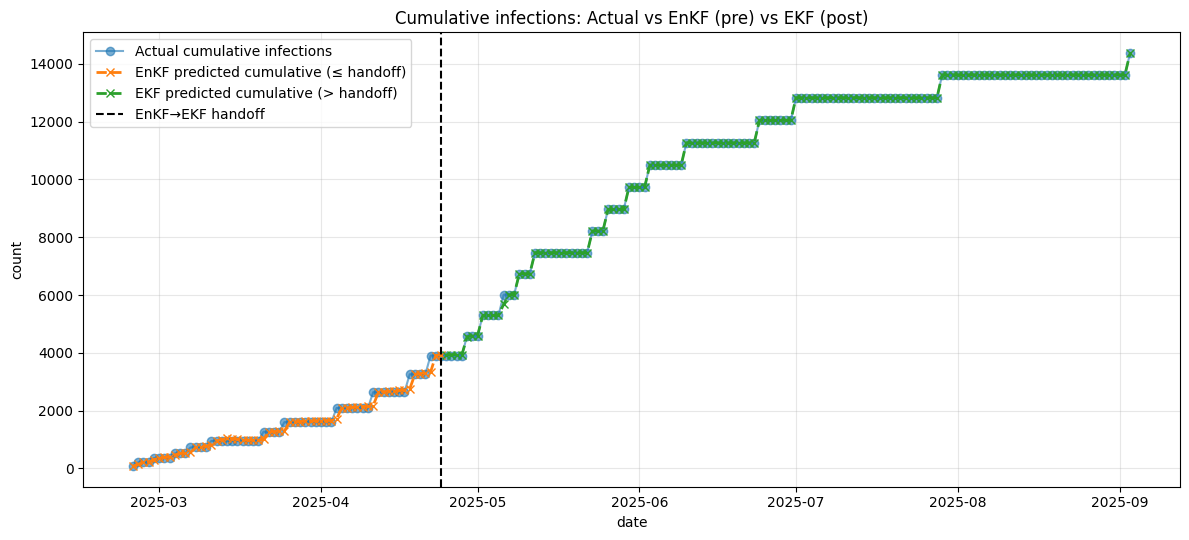

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

# ================================
# EnKF/EKF helpers
# ================================

def sird_step_aug(state_aug, N, dt):
    """
    State (augmented): [S, I, R, D, C, beta, gamma, delta]
    C is cumulative infections.
    """
    S, I, R, D, C, beta, gamma, delta = state_aug
    new_infections = beta * S * I / N

    dS = -new_infections
    dI = new_infections - gamma * I - delta * I
    dR = gamma * I
    dD = delta * I

    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    R_new = max(R + dR * dt, 0)
    D_new = max(D + dD * dt, 0)
    C_new = C + new_infections

    # random-walk params (small diffusion), clipped to [0,1]
    beta_new  = np.clip(beta  + np.random.normal(0, 0.0002), 0, 1)
    gamma_new = np.clip(gamma + np.random.normal(0, 0.0002), 0, 1)
    delta_new = np.clip(delta + np.random.normal(0, 0.0002), 0, 1)

    return np.array([S_new, I_new, R_new, D_new, C_new, beta_new, gamma_new, delta_new])

def enforce_mass(state_ens, N):
    """
    Ensure S >= 0 and S + I + R + D = N (closes the population).
    """
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1:4].sum(axis=1)
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:4] *= scale
        state_ens[over, 0] = 0.0
    return state_ens

def R_from_obs(y_vec):
    """
    Observation noise for [C, D].
    Floors prevent zero-variance issues.
    """
    y = np.asarray(y_vec, dtype=float)
    floors = np.array([0.005, 0.001])
    sigma  = np.maximum(0.005 * np.maximum(y, 1.0), floors)
    return np.diag(sigma**2)

def predict_measurement(state_ensemble):
    """
    Measurement is [C, D] from the augmented state.
    """
    C = state_ensemble[:, 4]
    D = state_ensemble[:, 3]
    return np.column_stack([C, D])

# ================================
# EnKF: run until parameter convergence
# returns convergence day + posterior means + EnKF C(t) series up to convergence
# ================================
def enkf_converge(merged_df, N, S0, I0, R0, D0, C0,
                  rtol=1e-3, alpha=1.2, ens_perturb=0.2, n_ens=200,
                  max_passes=10, verbose=True, rng_seed=42):
    Y_obs = merged_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()
    n_timesteps = len(merged_df)
    rng = np.random.default_rng(rng_seed)

    # init ensemble
    state_ens = np.zeros((n_ens, 8))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=4)
        IRD = np.maximum([I0, R0, D0] * perturb[:3], 0)
        S = max(N - IRD.sum(), 0)
        beta  = rng.uniform(0.1, 0.9)
        gamma = rng.uniform(0.1, 0.9)
        delta = rng.uniform(0.0001, 0.001)
        C = C0
        state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

    ensemble_params_hist = np.full((n_timesteps, n_ens, 3), np.nan)
    converged_day = None
    converg_counter = 0
    converged = False
    pass_idx = 0

    enkf_meanC_by_day = []  # record mean EnKF cumulative infections per day

    while pass_idx < max_passes and not converged:
        pass_idx += 1
        for k in range(n_timesteps):
            # ----- forecast -----
            for i in range(n_ens):
                state_ens[i] = sird_step_aug(state_ens[i], N, 1.0)
            state_ens = enforce_mass(state_ens, N)

            # ----- analysis -----
            meas_pred = predict_measurement(state_ens)
            y_obs_k   = Y_obs[k]
            Rk        = R_from_obs(y_obs_k)
            obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

            aug_mean  = np.mean(state_ens, axis=0)
            meas_mean = np.mean(meas_pred, axis=0)
            X = state_ens - aug_mean          # (n_ens, 8)
            Y = meas_pred - meas_mean         # (n_ens, 2)
            C_xy = (X.T @ Y) / (n_ens - 1)    # (8, 2)
            C_yy = (Y.T @ Y) / (n_ens - 1)    # (2, 2)
            Kk   = C_xy @ np.linalg.inv(C_yy + Rk)

            for i in range(n_ens):
                innovation = obs_perturbed[i] - meas_pred[i]
                state_ens[i] = state_ens[i] + alpha * (Kk @ innovation)
            # enforce mass + nonnegativity
            state_ens = enforce_mass(state_ens, N)

            # --- CLIP parameters to [0,1] after analysis (prevent params leaving feasible range) ---
            state_ens[:, 5:8] = np.clip(state_ens[:, 5:8], 0.0, 1.0)

            # keep cumulative monotone vs last obs (numerical safety)
            if k > 0:
                last_obs_C = Y_obs[k-1, 0]
                state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)

            # record mean C(t)
            enkf_meanC_by_day.append(np.mean(state_ens[:, 4]))

            # param tracking + convergence check
            ensemble_params_hist[k] = state_ens[:, 5:]
            if k > 0:
                prev_mean = np.mean(ensemble_params_hist[k-1], axis=0)
                curr_mean = np.mean(state_ens[:, 5:], axis=0)
                rel_change = np.linalg.norm(curr_mean - prev_mean, ord=np.inf) / (np.linalg.norm(prev_mean) + 1e-9)
                if rel_change < rtol:
                    converg_counter += 1
                    if converg_counter >= 1 and converged_day is None:
                        converged_day = k
                        converged = True
                        break
                else:
                    converg_counter = 0

    # fallback if no convergence
    if converged_day is None:
        converged_day = n_timesteps - 1

    # posterior means at convergence (analysis state still in state_ens)
    post_state_mean = np.mean(state_ens, axis=0)[:5]   # [S,I,R,D,C]
    post_param_mean = np.mean(state_ens, axis=0)[5:]   # [beta,gamma,delta]

    if verbose:
        print(f"ENKF converged at day {converged_day} with mean parameters:")
        print(f"  beta={post_param_mean[0]:.5f}, gamma={post_param_mean[1]:.5f}, delta={post_param_mean[2]:.5f}")

    return {
        'converged_day': int(converged_day),
        'post_state_mean': post_state_mean,                  # [S,I,R,D,C]
        'mean_greeks': post_param_mean,                      # [beta,gamma,delta]
        'enkf_C_series': np.array(enkf_meanC_by_day[:converged_day+1])  # C(t) up to handoff
    }

# ================================
# EKF on a sliced df, initialized from EnKF posterior at handoff
# ================================
def run_ekf_with_init(merged_df_slice, N, S0, I0, D0, C0, beta0, gamma0, delta0):
    dt = 1.0
    n_steps = len(merged_df_slice)
    if n_steps < 2:
        print("EKF: not enough points in the slice to run (need ≥ 2).")
        return {'x_est': None, 'C_est': None, 'D_est': None, 'dates': merged_df_slice['date'].to_numpy()}

    # x = [S, I, D, C, beta, gamma, delta]
    x0 = np.array([S0, I0, D0, C0, beta0, gamma0, delta0], dtype=float)
    P0 = np.diag([
        (0.05 * max(S0, 1.0))**2,  # S
        (0.20 * max(I0, 1.0))**2,  # I
        (0.20 * max(D0, 1.0))**2,  # D
        (0.10 * max(C0, 1.0))**2,  # C
        1e-2, 1e-3, 1e-4           # beta, gamma, delta
    ])
    R_cov = np.diag([0.05**2, 0.01**2])   # noise on [C, D]

    def f_continuous(x, N):
        S, I, D, C, beta, gamma, delta = x
        dS = -beta * S * I / N
        dI = beta * S * I / N - gamma * I - delta * I
        dD = delta * I
        dC = beta * S * I / N
        return np.array([dS, dI, dD, dC, 0, 0, 0])

    def compute_Q(x, N):
        S, I, D, C, beta, gamma, delta = x
        p1 = max(beta * S * I / N, 0.0)  # infection
        p2 = max(gamma * I,       0.0)   # recovery
        p3 = max(delta * I,       0.0)   # death
        #                S    I    D    C   params...
        lam1 = np.array([-1, +1,  0, +1, 0, 0, 0])  # infection also raises C
        lam2 = np.array([ 0, -1,  0,  0, 0, 0, 0])  # recovery
        lam3 = np.array([ 0, -1, +1,  0, 0, 0, 0])  # death
        Q_SID = p1*np.outer(lam1, lam1) + p2*np.outer(lam2, lam2) + p3*np.outer(lam3, lam3)
        Q = np.zeros((7,7))
        Q[:4, :4] += Q_SID[:4, :4]
        Q[4,4] = 1e-6; Q[5,5] = 1e-7; Q[6,6] = 1e-8
        return Q

    def jacobian_F(x, N):
        S, I, D, C, beta, gamma, delta = x
        F = np.eye(7)
        F[0,0] += -beta * I / N * dt
        F[0,1] += -beta * S / N * dt
        F[0,4] += -S * I / N * dt

        F[1,0] +=  beta * I / N * dt
        F[1,1] += ((beta * S / N) - gamma - delta) * dt
        F[1,4] +=  S * I / N * dt
        F[1,5] += -I * dt
        F[1,6] += -I * dt

        F[2,1] +=  delta * dt

        F[3,0] +=  beta * I / N * dt
        F[3,1] +=  beta * S / N * dt
        F[3,4] +=  S * I / N * dt  # dC/dbeta * dt
        return F

    def h(x, N):
        S, I, D, C, beta, gamma, delta = x
        return np.array([C, D])

    def jacobian_H(x, N):
        H = np.zeros((2, 7))
        H[0, 3] = 1  # C
        H[1, 2] = 1  # D
        return H

    x_est = np.zeros((7, n_steps))
    P_est = np.zeros((7, 7, n_steps))
    x_est[:, 0] = x0
    P = P0

    for k in range(1, n_steps):
        x_prev = x_est[:, k-1].copy()
        P_prev = P.copy()

        # ---- predict ----
        f_x   = f_continuous(x_prev, N)
        x_pred = x_prev + f_x * dt
        F      = jacobian_F(x_prev, N)
        Q_k    = compute_Q(x_prev, N)
        P_pred = F @ P_prev @ F.T + Q_k

        # monotone guards for totals (numerical safety)
        x_pred[3] = max(x_est[3, k-1], x_pred[3])  # C non-decreasing
        x_pred[2] = max(x_est[2, k-1], x_pred[2])  # D non-decreasing

        # ---- update ----
        y_obs = merged_df_slice[['Cumulative Infected', 'Cumulative Deaths']].iloc[k].to_numpy()
        z_pred = h(x_pred, N)
        Hm = jacobian_H(x_pred, N)

        S_mat = Hm @ P_pred @ Hm.T + R_cov
        K = P_pred @ Hm.T @ np.linalg.inv(S_mat)

        innovation = y_obs - z_pred
        x_upd = x_pred + K @ innovation

        # guards: enforce monotonicity and non-negativity BEFORE clipping params
        x_upd[3] = max(x_est[3, k-1], x_upd[3])
        x_upd[2] = max(x_est[2, k-1], x_upd[2])
        x_upd = np.maximum(x_upd, 0.0)

        # --- CLIP the greeks (beta,gamma,delta) to [0,1]
        x_upd[4] = np.clip(x_upd[4], 0.0, 1.0)  # beta
        x_upd[5] = np.clip(x_upd[5], 0.0, 1.0)  # gamma
        x_upd[6] = np.clip(x_upd[6], 0.0, 1.0)  # delta

        # Joseph form (stable covariance update)
        I7 = np.eye(7)
        P = (I7 - K @ Hm) @ P_pred @ (I7 - K @ Hm).T + K @ R_cov @ K.T

        x_est[:, k] = x_upd
        P_est[:, :, k] = P

    S_est, I_est, D_est, C_est, beta_est, gamma_est, delta_est = x_est
    actual_C = merged_df_slice['Cumulative Infected'].to_numpy()
    actual_D = merged_df_slice['Cumulative Deaths'].to_numpy()

    rmse_C = root_mean_squared_error(actual_C, C_est)
    r2_C   = r2_score(actual_C, C_est)
    rmse_D = root_mean_squared_error(actual_D, D_est)
    r2_D   = r2_score(actual_D, D_est)
    print(f"EKF (slice) RMSE(C): {rmse_C:.3f}, R²={r2_C:.4f} | RMSE(D): {rmse_D:.3f}, R²={r2_D:.4f}")

    return {
        'x_est': x_est,
        'C_est': C_est,
        'D_est': D_est,
        'dates': merged_df_slice['date'].to_numpy()
    }

# ================================
# Run: EnKF → EKF (start day after convergence) + single plot
# ================================
result_enkf = enkf_converge(merged_df, N, S0, I0, R0, D0, C0)
conv_day = result_enkf['converged_day']
S_enkf, I_enkf, R_enkf, D_enkf, C_enkf = result_enkf['post_state_mean']
beta_enkf, gamma_enkf, delta_enkf      = result_enkf['mean_greeks']
enkf_C_series = result_enkf['enkf_C_series']  # length = conv_day + 1

# Slice EKF to start AFTER convergence
start_idx = conv_day + 1
ekf_df = merged_df.iloc[start_idx:].reset_index(drop=True)

if len(ekf_df) >= 2:
    result_ekf = run_ekf_with_init(
        ekf_df, N,
        S0=S_enkf, I0=I_enkf, D0=D_enkf, C0=C_enkf,
        beta0=beta_enkf, gamma0=gamma_enkf, delta0=delta_enkf
    )
    ekf_dates = result_ekf['dates']
    ekf_C_est = result_ekf['C_est']
else:
    ekf_dates = np.array([])
    ekf_C_est = np.array([])

# ================================
# Single plot: Actual vs EnKF (pre-handoff) vs EKF (post-handoff)
# ================================
all_dates = merged_df['date'].to_numpy()
actual_C  = merged_df['Cumulative Infected'].to_numpy()
handoff_date = merged_df['date'].iloc[conv_day]

plt.figure(figsize=(12, 5.5))

# Actual (full)
plt.plot(all_dates, actual_C, 'o-', label='Actual cumulative infections', alpha=0.6)

# EnKF predicted C up to convergence day
plt.plot(all_dates[:conv_day+1], enkf_C_series, 'x--', linewidth=2,
         label='EnKF predicted cumulative (≤ handoff)')

# EKF predicted C after convergence day (if available)
if ekf_C_est is not None and len(ekf_C_est) > 0:
    plt.plot(ekf_dates, ekf_C_est, 'x--', linewidth=2,
             label='EKF predicted cumulative (> handoff)')

# Dashed vertical handoff line
plt.axvline(handoff_date, ls='--', c='k', label='EnKF→EKF handoff')

plt.title("Cumulative infections: Actual vs EnKF (pre) vs EKF (post)")
plt.xlabel("date"); plt.ylabel("count")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Rollover thread

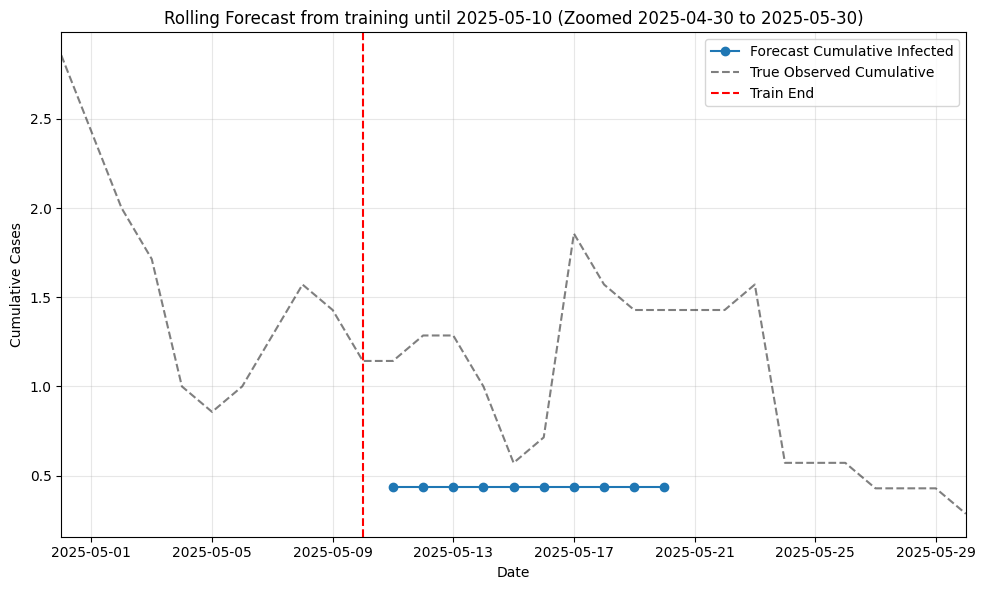

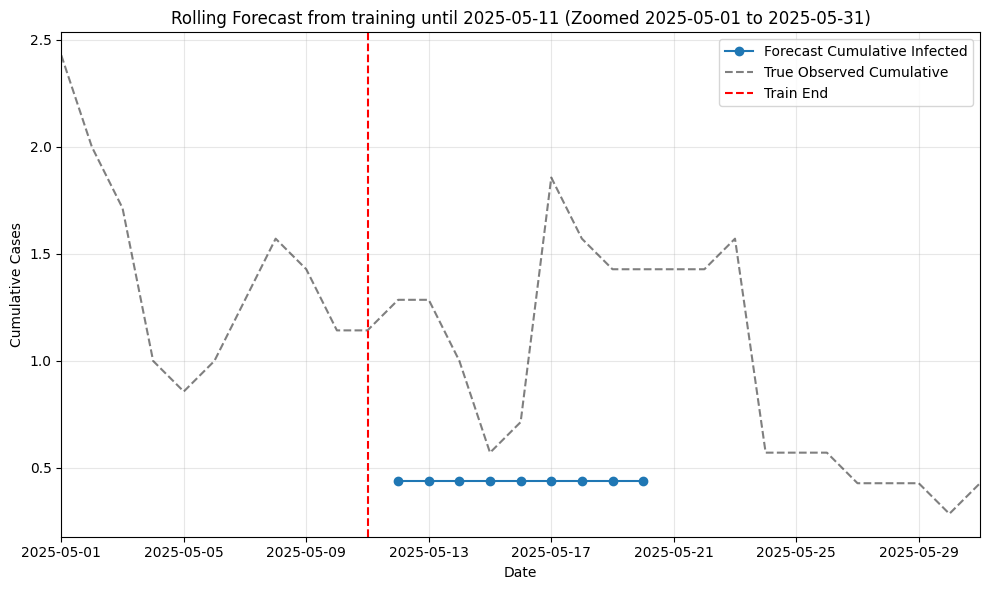

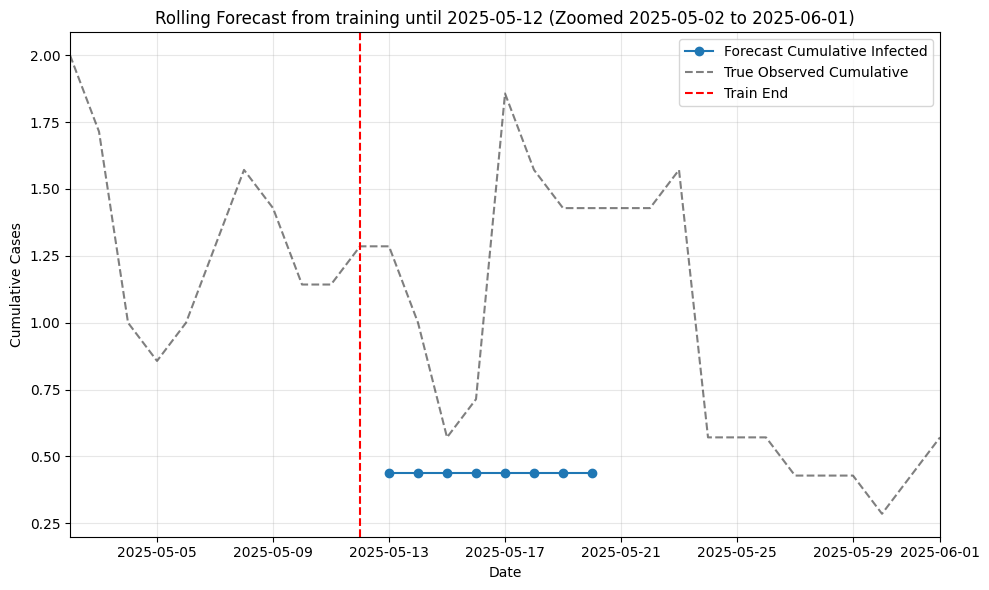

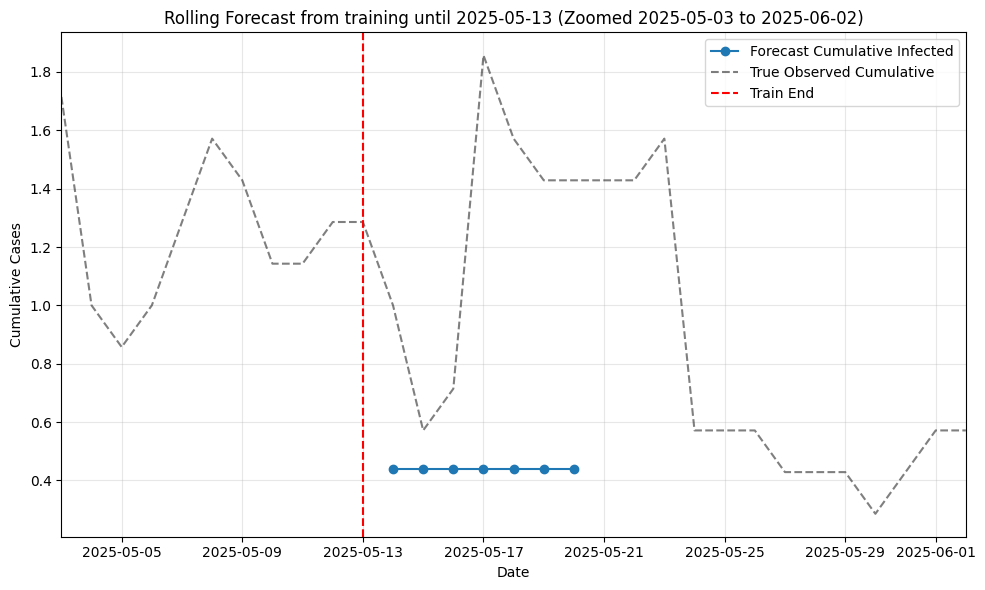

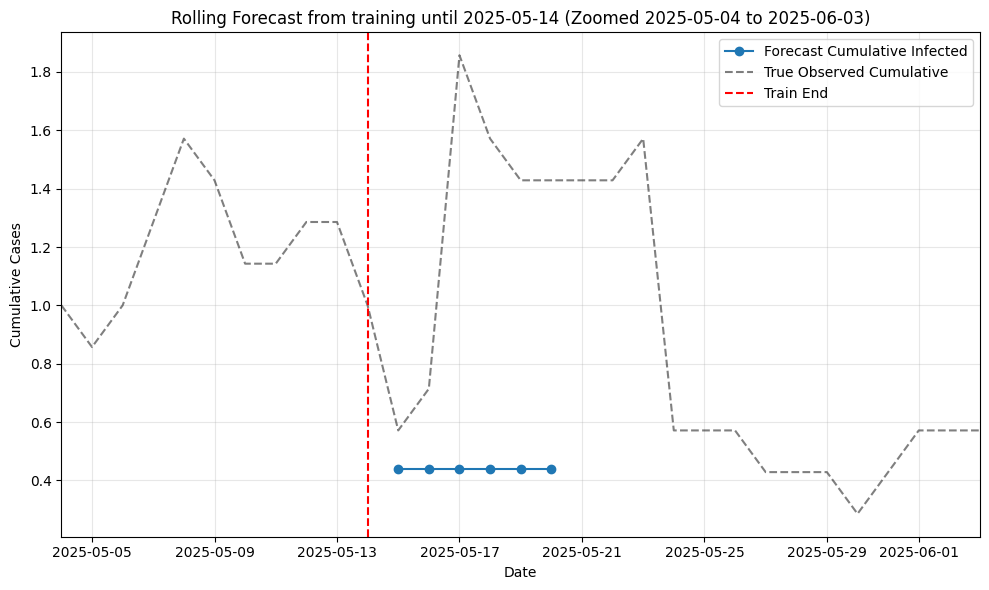

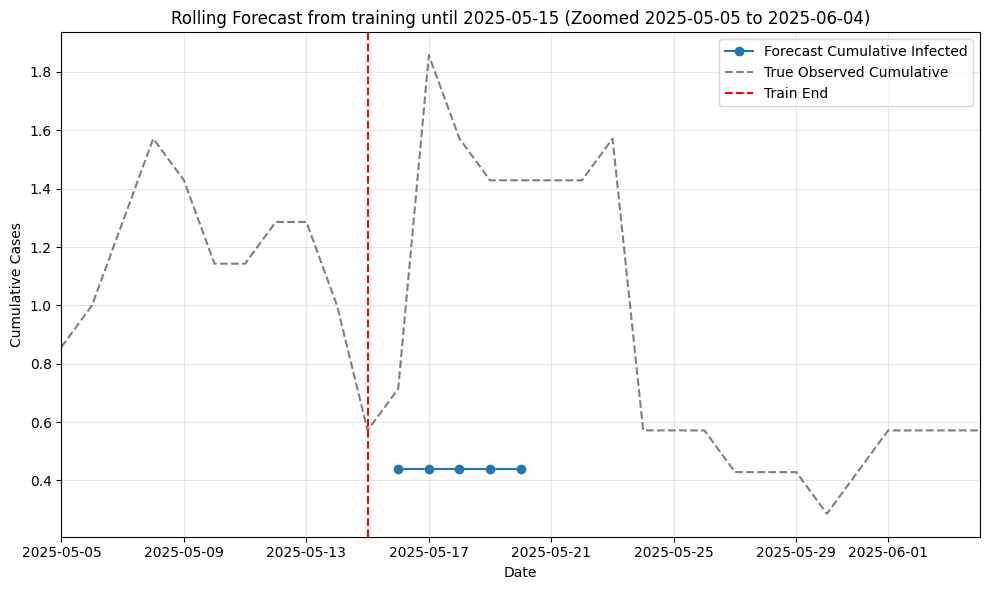

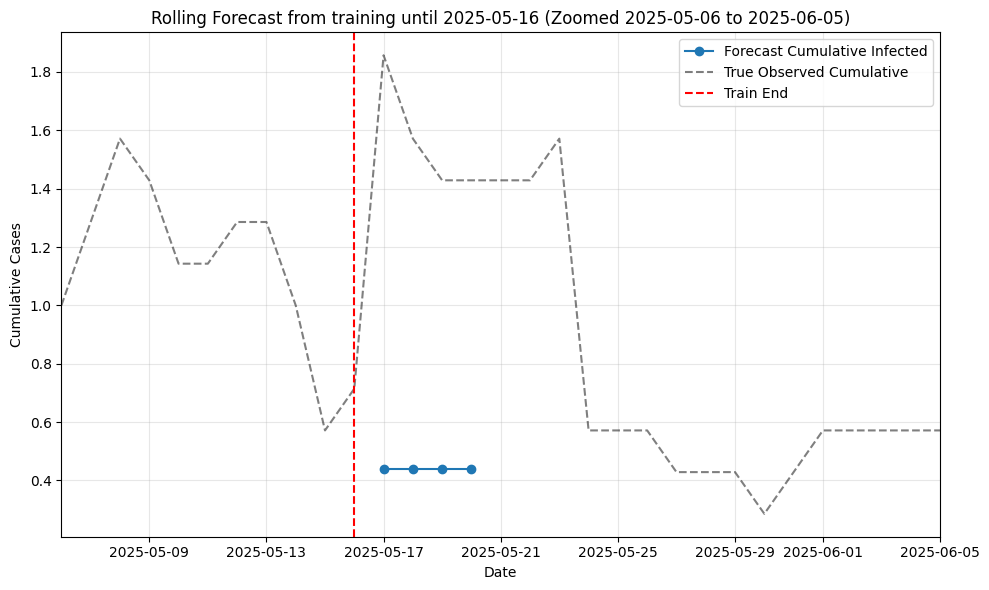

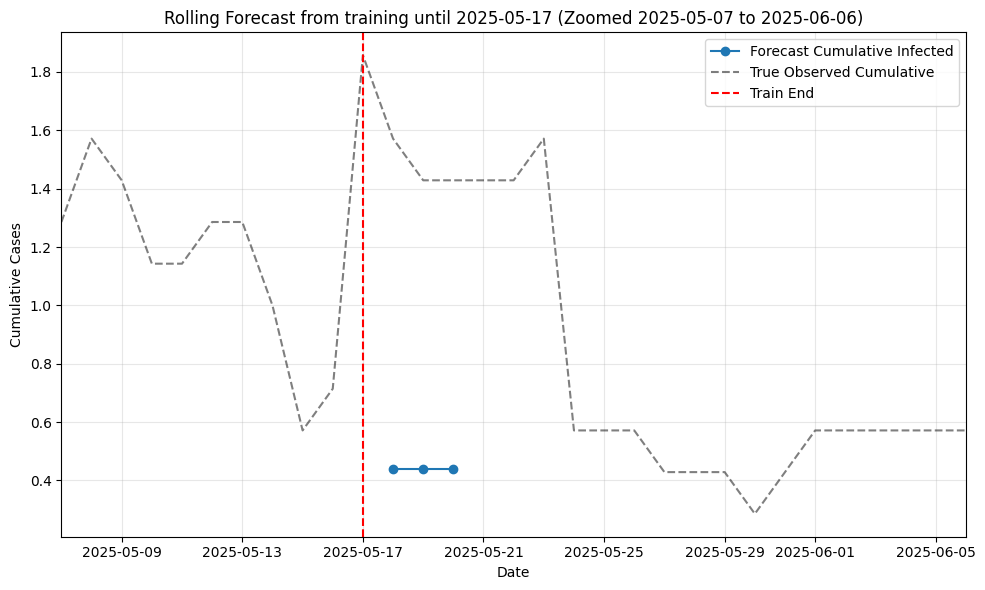

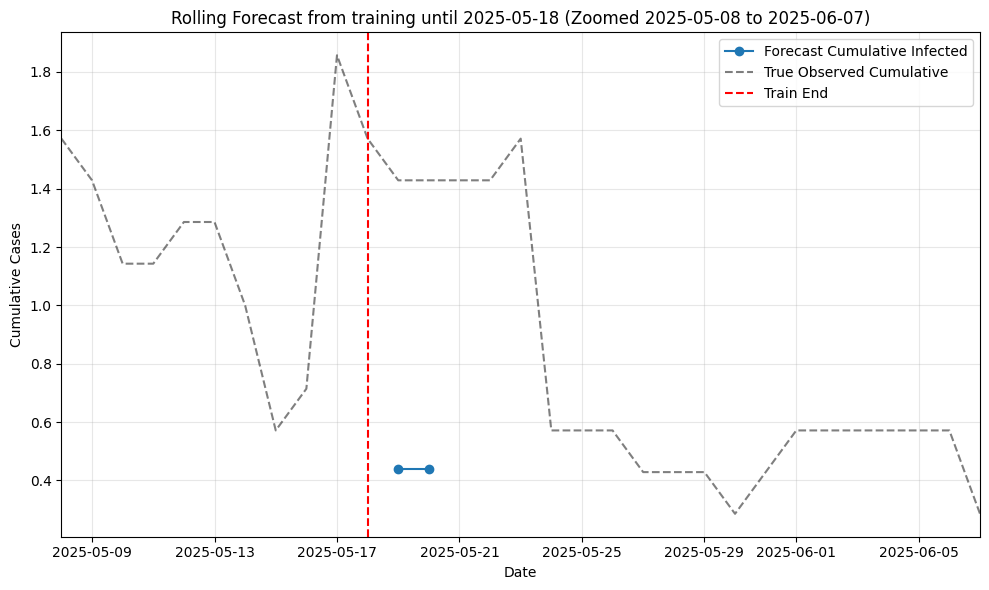

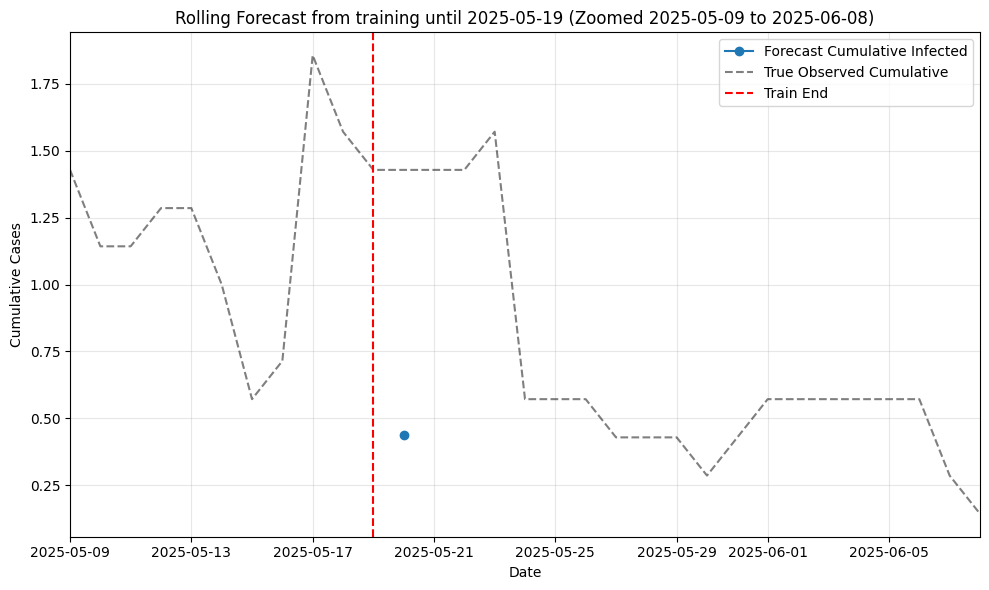

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- USER-SET VARIABLES AT TOP ---
iterate = 10  # Initial forecast window size (max number of rolling forecasts)
train_start = merged_df['date'].iloc[0]
train_end_date = pd.Timestamp('2025-05-10')  # Final allowed training end date

dates = merged_df['date'].to_numpy()
n_total_days = len(merged_df)
train_start_idx = merged_df[merged_df['date'] == train_start].index[0]

# Resolve train_end_idx_absolute with closest date <= train_end_date
if train_end_date not in merged_df['date'].values:
    possible = merged_df[merged_df['date'] <= train_end_date]
    if len(possible) == 0:
        raise ValueError(f"train_end_date {train_end_date.date()} is before earliest date.")
    train_end_idx_absolute = possible.index[-1]
    actual_train_end_date = merged_df.loc[train_end_idx_absolute, 'date']
    print(f"Using closest earlier date {actual_train_end_date.date()} for train_end_date.")
else:
    train_end_idx_absolute = merged_df[merged_df['date'] == train_end_date].index[0]

rollover_forecasts = []

for window_offset in range(iterate):
    train_end_idx = train_end_idx_absolute + window_offset
    if train_end_idx >= n_total_days - 1:
        break

    forecast_horizon = max(iterate - window_offset, 1)

    # Initialize EKF arrays
    x_est = np.zeros((6, n_total_days))
    P_est = np.zeros((6, 6, n_total_days))
    x_est[:, 0] = x0.copy()
    P = P0.copy()

    # Assimilate all data up to train_end_idx
    for k in range(1, train_end_idx + 1):
        x_prev = x_est[:, k-1].copy()
        P_prev = P.copy()
        f_x = f_continuous(x_prev, N)
        x_pred = x_prev + f_x * dt
        F = jacobian_F(x_prev, N)
        Q_k = compute_Q(x_prev, N)
        P_pred = F @ P_prev @ F.T + Q_k
        x_pred[3] = max(x_est[3, k-1], x_pred[3])
        x_pred[2] = max(x_est[2, k-1], x_pred[2])
        y_obs = merged_df[['Infected', 'Deaths']].iloc[k].to_numpy()
        z_pred = h(x_pred, N)
        H = jacobian_H(x_pred, N)
        S_mat = H @ P_pred @ H.T + R_cov
        K = P_pred @ H.T @ np.linalg.inv(S_mat)
        innovation = y_obs - z_pred
        x_upd = x_pred + K @ innovation
        x_upd = np.maximum(x_upd, 0.0)
        x_upd[4] = np.clip(x_upd[4], 0, 1)
        x_upd[5] = np.clip(x_upd[5], 0, 1)
        # x_upd[6] = np.clip(x_upd[6], 0, 1)
        x_upd[3] = max(x_est[3, k-1], x_upd[3])
        x_upd[2] = max(x_est[2, k-1], x_upd[2])
        I7 = np.eye(6)
        P = (I7 - K @ H) @ P_pred @ (I7 - K @ H).T + K @ R_cov @ K.T
        x_est[:, k] = x_upd
        P_est[:, :, k] = P

    # Forecast without assimilation
    forecasts = []
    x_current = x_est[:, train_end_idx].copy()
    for fh in range(forecast_horizon):
        f_x = f_continuous(x_current, N)
        x_forecast = x_current + f_x * dt
        x_forecast[3] = max(x_current[3], x_forecast[3])
        x_forecast[2] = max(x_current[2], x_forecast[2])
        x_forecast[4] = np.clip(x_forecast[4], 0, 1)
        x_forecast[5] = np.clip(x_forecast[5], 0, 1)
        # x_forecast[6] = np.clip(x_forecast[6], 0, 1)
        forecasts.append(x_forecast.copy())
        x_current = x_forecast.copy()

    forecast_dates = dates[(train_end_idx + 1):(train_end_idx + 1 + forecast_horizon)]
    forecast_array = np.array(forecasts)

    rollover_forecasts.append({
        'train_end_date': merged_df['date'].iloc[train_end_idx],
        'forecast_dates': forecast_dates,
        'forecast_array': forecast_array,
    })

# Plot rolling forecasts with zoom
for entry in rollover_forecasts:
    train_end = entry['train_end_date']
    forecast_dates = entry['forecast_dates']
    forecast_array = entry['forecast_array']

    zoom_start_date = train_end - pd.Timedelta(days=10)
    plot_end_date = train_end + pd.Timedelta(days=20)


    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'C': forecast_array[:, 3],  # cumulative infected
    })

    forecast_df_zoom = forecast_df[(forecast_df['Date'] >= zoom_start_date) & (forecast_df['Date'] <= plot_end_date)]
    true_zoom = merged_df[(merged_df['date'] >= zoom_start_date) & (merged_df['date'] <= plot_end_date)]

    plt.figure(figsize=(10, 6))
    train_date = pd.Timestamp(train_end).date() if not isinstance(train_end, pd.Timestamp) else train_end.date()
    plt.title(f'Rolling Forecast from training until {train_date} (Zoomed {zoom_start_date.date()} to {plot_end_date.date()})')
    plt.plot(forecast_df_zoom['Date'], forecast_df_zoom['C'], '-o', label='Forecast Cumulative Infected')
    plt.plot(true_zoom['date'], true_zoom['Infected'], 'k--', alpha=0.5, label='True Observed Cumulative')
    plt.axvline(train_end, color='r', linestyle='--', label='Train End')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Cases')
    plt.xlim(zoom_start_date, plot_end_date)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
print("x0 shape:", x0.shape)
print("x0 values:", x0)

x0 shape: (7,)
x0 values: [2.27213265e+06 9.00000000e+01 0.00000000e+00 9.00000000e+01
 7.70000000e-01 4.20000000e-01 1.00000000e-02]


In [ ]:
print("Desired final train_end_date:", train_end_date)
print("Actual max train_end_idx_absolute:", train_end_idx_absolute, merged_df['date'].iloc[train_end_idx_absolute])
for entry in rollover_forecasts:
    print("Stored train_end_date for plot:", entry['train_end_date'])


Desired final train_end_date: 2025-04-10 00:00:00
Actual max train_end_idx_absolute: 45 2025-04-10 00:00:00
Stored train_end_date for plot: 2025-02-24 00:00:00
Stored train_end_date for plot: 2025-02-25 00:00:00
Stored train_end_date for plot: 2025-02-26 00:00:00
Stored train_end_date for plot: 2025-02-27 00:00:00
Stored train_end_date for plot: 2025-02-28 00:00:00
Stored train_end_date for plot: 2025-03-01 00:00:00
Stored train_end_date for plot: 2025-03-02 00:00:00
Stored train_end_date for plot: 2025-03-03 00:00:00
Stored train_end_date for plot: 2025-03-04 00:00:00
Stored train_end_date for plot: 2025-03-05 00:00:00


# EKF Without Cumulative State (for raw data)

RMSE(Infected): 0.201, R²=0.9981
RMSE(Deaths):   0.055, R²=0.7470


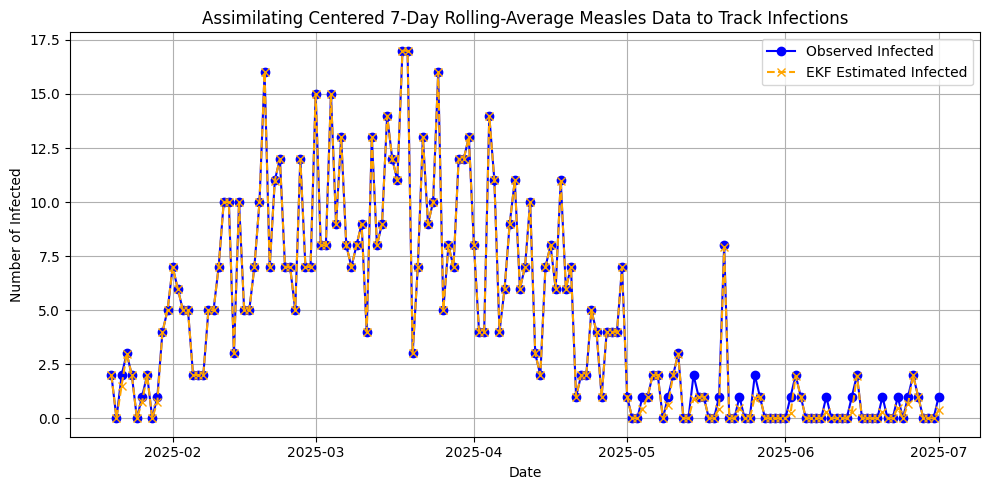

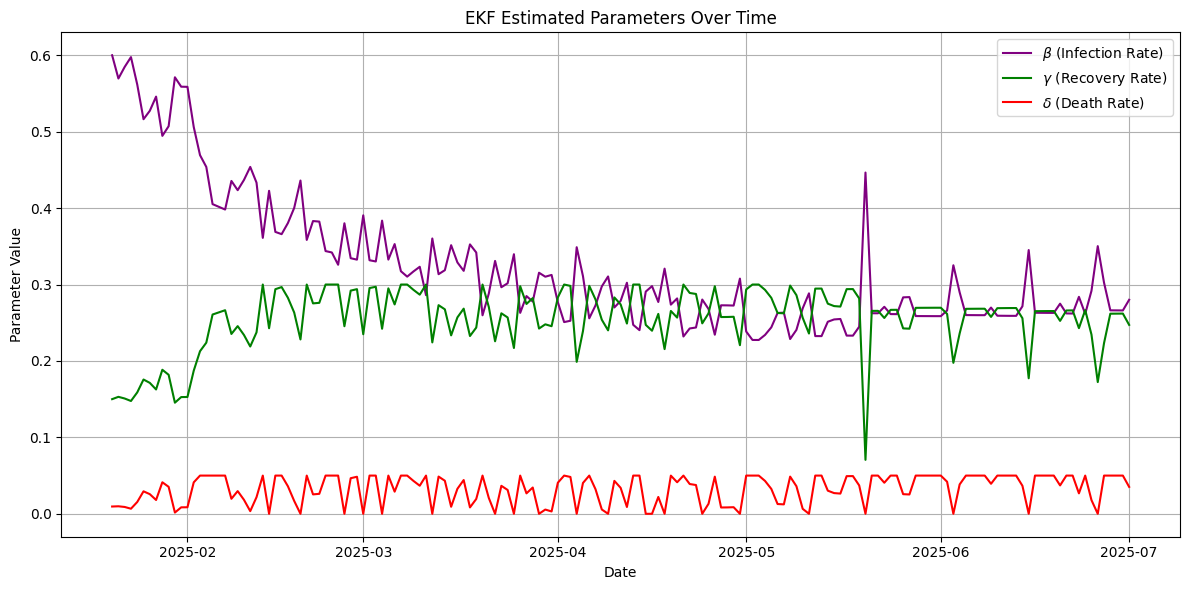

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score

# Initialize from data
D0 = int(merged_df['Deaths'].iloc[0])
C0 = int(merged_df['Infected'].iloc[0])
I0 = float(C0)
S0 = float(N - C0 - D0)
beta0, gamma0, delta0 = 0.6, 0.15, 2/210

# State vector: [S, I, D, beta, gamma, delta]
x0 = np.array([S0, I0, D0, beta0, gamma0, delta0], dtype=float)

# Covariance initialization
P0 = np.diag([
    (0.05 * max(S0, 1.0))**2,
    (0.20 * max(I0, 1.0))**2,
    (0.20 * max(D0, 1.0))**2,
    1e-2,  # beta
    1e-3,  # gamma
    1e-4   # delta
])

dt = 1.0
n_steps = len(merged_df)

# Measurement noise covariance (observing I and D)
R_cov = np.diag([0.05**2, 0.01**2])

# Process function for SIRD
def f_continuous(x, N):
    S, I, D, beta, gamma, delta = x
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dD = delta * I
    dBeta = 0
    dGamma = 0
    dDelta = 0
    return np.array([dS, dI, dD, dBeta, dGamma, dDelta])

# Process noise
def compute_Q(x, N):
    S, I, D, beta, gamma, delta = x
    p1 = max(beta * S * I / N, 0.0)
    p2 = max(gamma * I, 0.0)
    p3 = max(delta * I, 0.0)
    lam1 = np.array([-1, +1, 0, 0, 0, 0])
    lam2 = np.array([0, -1, 0, 0, 0, 0])
    lam3 = np.array([0, -1, +1, 0, 0, 0])
    Q_SID = (
        p1 * np.outer(lam1, lam1)
        + p2 * np.outer(lam2, lam2)
        + p3 * np.outer(lam3, lam3)
    )
    Q = np.zeros((6, 6))
    Q[:3, :3] += Q_SID[:3, :3]
    Q[3, 3] = 1e-3   # beta drift
    Q[4, 4] = 1e-3   # gamma drift
    Q[5, 5] = 1e-3   # delta drift
    return Q

def jacobian_F(x, N):
    S, I, D, beta, gamma, delta = x
    F = np.eye(6)
    F[0, 0] += -beta * I / N * dt
    F[0, 1] += -beta * S / N * dt
    F[0, 3] += -S * I / N * dt
    F[1, 0] += beta * I / N * dt
    F[1, 1] += (beta * S / N - gamma - delta) * dt
    F[1, 3] += S * I / N * dt
    F[1, 4] += -I * dt
    F[1, 5] += -I * dt
    F[2, 1] += delta * dt
    return F

def h(x, N):
    S, I, D, beta, gamma, delta = x
    return np.array([I, D])

def jacobian_H(x, N):
    H = np.zeros((2, 6))
    H[0, 1] = 1
    H[1, 2] = 1
    return H

# Filtering loop
x_est = np.zeros((6, n_steps))
P_est = np.zeros((6, 6, n_steps))
x_est[:, 0] = x0
P = P0

for k in range(1, n_steps):
    x_prev = x_est[:, k-1].copy()
    P_prev = P.copy()
    f_x = f_continuous(x_prev, N)
    x_pred = x_prev + f_x * dt
    F = jacobian_F(x_prev, N)
    Q_k = compute_Q(x_prev, N)
    P_pred = F @ P_prev @ F.T + Q_k
    y_obs = merged_df[['Infected', 'Deaths']].iloc[k].to_numpy()
    y_obs_vec = np.array(y_obs)
    z_pred = h(x_pred, N)
    H = jacobian_H(x_pred, N)
    S_mat = H @ P_pred @ H.T + R_cov
    K = P_pred @ H.T @ np.linalg.inv(S_mat)
    innovation = y_obs_vec - z_pred
    x_upd = x_pred + K @ innovation
    x_upd = np.maximum(x_upd, 0.0)
    # Clip parameters to requested ranges
    # x_upd[3] = np.clip(x_upd[3], 0.0, 1)     # beta
    x_upd[4] = np.clip(x_upd[4], 0.0, 0.3)     # gamma
    x_upd[5] = np.clip(x_upd[5], 0.0, 0.05)   # delta
    I6 = np.eye(6)
    P = (I6 - K @ H) @ P_pred @ (I6 - K @ H).T + K @ R_cov @ K.T
    x_est[:, k] = x_upd
    P_est[:, :, k] = P

# Extract results
S_est, I_est, D_est, beta_est, gamma_est, delta_est = x_est
actual_I = merged_df['Infected'].to_numpy()
actual_D = merged_df['Deaths'].to_numpy()

# Metrics
rmse_I = root_mean_squared_error(actual_I, I_est)
r2_I = r2_score(actual_I, I_est)
rmse_D = root_mean_squared_error(actual_D, D_est)
r2_D = r2_score(actual_D, D_est)
print(f"RMSE(Infected): {rmse_I:.3f}, R²={r2_I:.4f}")
print(f"RMSE(Deaths):   {rmse_D:.3f}, R²={r2_D:.4f}")

dates = merged_df['date']

# Plot I (infected)
plt.figure(figsize=(10, 5))
plt.plot(dates, actual_I, 'o-', label="Observed Infected", color='blue')
plt.plot(dates, I_est, 'x--', label="EKF Estimated Infected", color='orange')
plt.xlabel("Date")
plt.ylabel("Number of Infected")
plt.title("Assimilating Centered Daily Measles Data to Track Infections")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot beta, gamma, delta evolution
plt.figure(figsize=(12, 6))
plt.plot(dates, beta_est, label=r'$\beta$ (Infection Rate)', color='purple')
plt.plot(dates, gamma_est, label=r'$\gamma$ (Recovery Rate)', color='green')
plt.plot(dates, delta_est, label=r'$\delta$ (Death Rate)', color='red')
plt.xlabel("Date")
plt.ylabel("Parameter Value")
plt.title("EKF Estimated Parameters Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


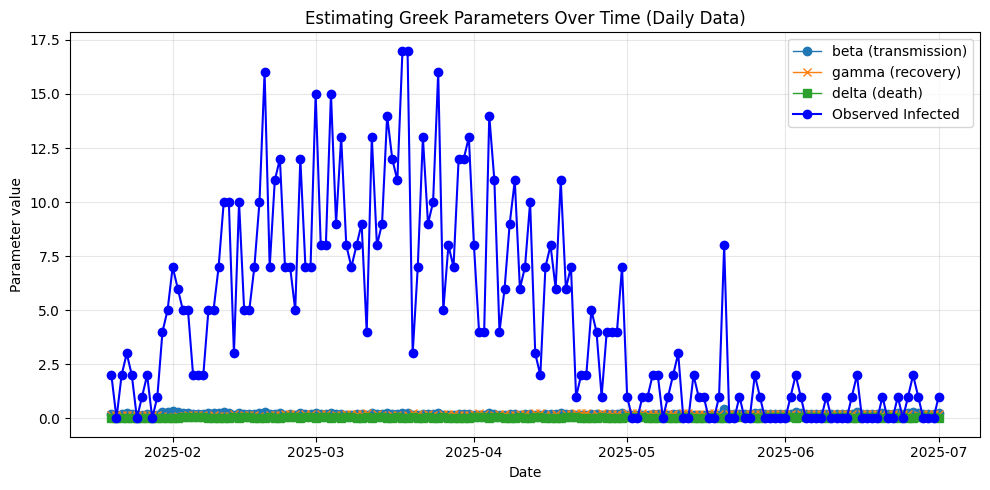

In [30]:
# --- plot greeks (plain parameters) ---
import matplotlib.pyplot as plt

dates = merged_df['date']  # or dates variable you already have

beta_series = x_est[3, :]   # beta over time
gamma_series = x_est[4, :]  # gamma over time
delta_series = x_est[5, :]  # delta over time

plt.figure(figsize=(10,5))
plt.plot(dates, beta_series, label='beta (transmission)', marker='o', linewidth=1)
plt.plot(dates, gamma_series, label='gamma (recovery)', marker='x', linewidth=1)
plt.plot(dates, delta_series, label='delta (death)', marker='s', linewidth=1)
plt.plot(dates, actual_I, 'o-', label="Observed Infected", color='blue')
plt.xlabel('Date')
plt.ylabel('Parameter value')
plt.title('Estimating Greek Parameters Over Time (Daily Data)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


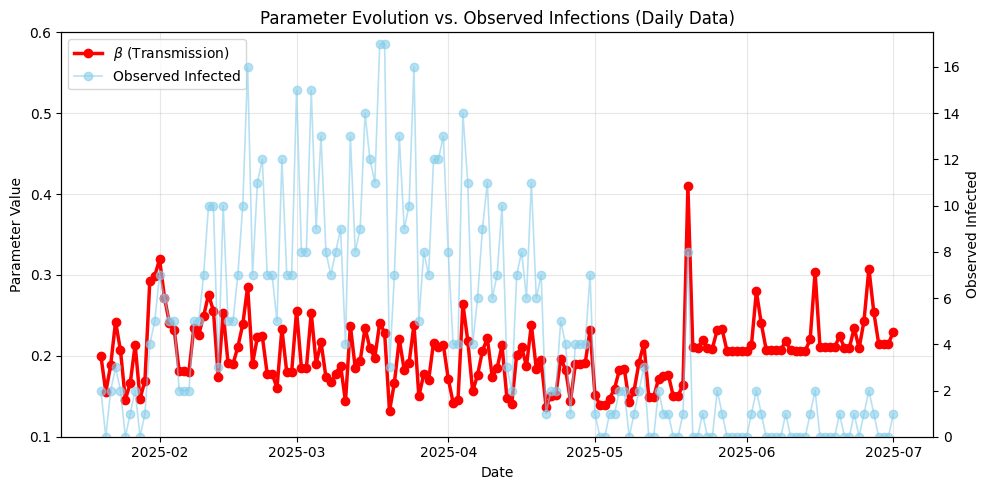

In [31]:
import matplotlib.pyplot as plt

dates = merged_df['date']

beta_series = x_est[3, :]
gamma_series = x_est[4, :]
delta_series = x_est[5, :]

fig, ax1 = plt.subplots(figsize=(10, 5))

# --- Left y-axis: parameters ---
ax1.plot(dates, beta_series, label=r'$\beta$ (Transmission)', marker='o', linewidth=2.5, color='red')
# ax1.plot(dates, gamma_series, label=r'$\gamma$ (Recovery)', marker='x', linewidth=1, color='gray', alpha=0.5)
# ax1.plot(dates, delta_series, label=r'$\delta$ (Death)', marker='s', linewidth=1, color='gray', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Parameter Value')
ax1.set_ylim(0.1, 0.6)
ax1.grid(alpha=0.3)

# --- Right y-axis: observed infections ---
ax2 = ax1.twinx()
ax2.plot(dates, actual_I, 'o-', color='skyblue', label='Observed Infected', linewidth=1.2, alpha=0.6)
ax2.set_ylabel('Observed Infected')
ax2.set_ylim(0, 17.5)

# --- Combine legends from both axes ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Parameter Evolution vs. Observed Infections (Daily Data)')
plt.tight_layout()
plt.show()


In [32]:
# import pandas as pd

# dates = merged_df['date']
# predicted_infected = x_est[1, :]  # EKF infected estimate (index 1)
# true_infected = merged_df['Cumulative Infected'].to_numpy()

# # Make sure lengths align for CSV
# length = min(len(dates), len(predicted_infected), len(true_infected))
# df_save = pd.DataFrame({
#     'date': dates[:length],
#     'predicted_infected': predicted_infected[:length],
#     'true_infected': true_infected[:length]
# })

# csv_path = r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\combined graphs\raw_weekly.csv"
# df_save.to_csv(csv_path, index=False)



In [33]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load CSV
# df = pd.read_csv(csv_path)

# # Convert 'date' column to datetime
# df['date'] = pd.to_datetime(df['date'])

# # Plot
# plt.figure(figsize=(12,6))
# plt.plot(df['date'], df['ENKF Predicted'], label='')
# plt.plot(df['date'], df['True Infections'], label='')
# plt.plot(df['date'], df['EKF Predicted'], label='', color = 'purple')

# plt.xlabel('Date')
# plt.ylabel('Cumulative Infections')
# plt.title('EnKF and EKF to Predict Infections Using Cumulative Weekly Data')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
